In [ ]:
import os
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import layers, Input, Model
from sklearn.metrics import precision_score, recall_score 

In [ ]:
X_pathneg = 'rt-polarity.neg'
X_pathpos = 'rt-polarity.pos'

with open(X_pathneg, encoding = "ISO-8859-1") as file:
    X_listneg = file.readlines()

with open(X_pathpos, encoding = "ISO-8859-1") as file:
    X_listpos = file.readlines()
 
X_list = X_listneg + X_listpos
y_list = [0]*len(X_listneg) + [1]*len(X_listpos)

X_list = [classval[:-1] for classval in X_list]
classes = np.unique(y_list)
unique_letters = np.unique(X_list)

In [ ]:
embed_dim = 100
vectorizer = TextVectorization(max_tokens=20600, output_sequence_length=embed_dim)
text_ds = tf.data.Dataset.from_tensor_slices(X_list).batch(128) ## Read batches of 128 samples
vectorizer.adapt(text_ds)

In [ ]:
vocab = vectorizer.get_vocabulary()
vocab_to_index = dict(zip(vocab,range(len(vocab))))
index_to_vocab = dict(zip(range(len(vocab)),vocab))

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, train_size = 7/10, random_state = 1)

X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = to_categorical(y_train).astype(np.int64)
y_test = to_categorical(y_test).astype(np.int64)
y_test_labels = np.argmax(y_test, axis = 1)

In [ ]:
class models:

  def __init__(self, xtrain, ytrain, embed_layer):
    self.X_train = xtrain
    self.y_train = ytrain
    self.embedding_layer = embed_layer
    self.modmetrics = []

  def conf_mat(self, y_test):
    y_test = np.argmax(y_test, axis = 1)
    conf_mat = confusion_matrix(y_test, self.y_pred)
    return conf_mat

  def get_metrics(self,ytest,ypred):
    self.modmetrics.append([precision_score(ytest, ypred), recall_score(ytest, ypred)])
    return self

  def get_pred(self, X_test, y_test):
    modpreds = np.argmax(self.savedmodel.predict(X_test), axis = 1)
    y_test = np.argmax(y_test, axis = 1)
    self.get_metrics(y_test,modpreds)
    self.y_pred = modpreds
    return self

  def lstm_mod(self):
    classes = self.y_train.shape[1]
    int_sequences_input = Input(shape=(None,), dtype="int64")
    embedded_sequences = self.embedding_layer(int_sequences_input)
    x = layers.Bidirectional(layers.LSTM(20))(embedded_sequences)
    preds = layers.Dense(classes, activation="softmax")(x)
    model1 = Model(int_sequences_input, preds)
    #model1.summary()

    model1.compile(loss="categorical_crossentropy", optimizer="adam")
    model1.fit(self.X_train, self.y_train, batch_size=128, epochs=10)
    
    self.savedmodel = model1

    return self

  def gru_mod(self):
    classes = self.y_train.shape[1]    
    int_sequences_input = Input(shape=(None,), dtype="int64")
    embedded_sequences = self.embedding_layer(int_sequences_input)
    x = layers.Bidirectional(layers.GRU(20))(embedded_sequences)
    preds = layers.Dense(classes, activation="softmax")(x)
    model2 = Model(int_sequences_input, preds)
    #model2.summary()

    model2.compile(loss="categorical_crossentropy", optimizer="adam")
    model2.fit(self.X_train, self.y_train, batch_size=128, epochs=10)
    
    self.savedmodel = model2

    return self

  def rnn_mod(self):
    classes = self.y_train.shape[1]
    int_sequences_input = Input(shape=(None,), dtype="int64")
    embedded_sequences = self.embedding_layer(int_sequences_input)
    x = layers.Bidirectional(layers.SimpleRNN(20))(embedded_sequences)
    preds = layers.Dense(classes, activation="softmax")(x)
    model3 = Model(int_sequences_input, preds)
    #model3.summary()

    model3.compile(loss="categorical_crossentropy", optimizer="adam")
    model3.fit(self.X_train, self.y_train, batch_size=128, epochs=10)

    self.savedmodel = model3

    return self

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
def create_embed(filepath, myvocab, myembed_dim):
  path_to_glove_file = filepath
  vocab = myvocab
  embed_dim = myembed_dim
  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  num_tokens = len(vocab) 

  hits = 0 ## number of words that were found in the pretrained model
  misses = 0 ## number of words that were missing in the pretrained model
  word_index = dict(zip(vocab, range(len(vocab))))
  # Prepare embedding matrix for our word list
  embedding_matrix = np.zeros((num_tokens, embed_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1

  print("Converted %d words (%d misses)" % (hits, misses))

  embedding_layer = Embedding(num_tokens, embed_dim,
                              embeddings_initializer= Constant(embedding_matrix), 
                              trainable=False,
  )

  return embedding_layer

In [ ]:
embedding_layer = create_embed("drive/MyDrive/emb.txt", vocab, embed_dim)

rnn_obj3 = models(X_train, y_train, embedding_layer).rnn_mod()
rnn_obj3.get_pred(X_test, y_test)
rnn_mets3 = rnn_obj3.modmetrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  if __name__ == '__main__':


Converted 18233 words (2286 misses)
Epoch 1/10
59/59 [==============================] - 4s 47ms/step - loss: 0.7169
Epoch 2/10
59/59 [==============================] - 3s 46ms/step - loss: 0.6754
Epoch 3/10
59/59 [==============================] - 3s 46ms/step - loss: 0.6502
Epoch 4/10
59/59 [==============================] - 3s 47ms/step - loss: 0.6038
Epoch 5/10
59/59 [==============================] - 3s 46ms/step - loss: 0.5802
Epoch 6/10
59/59 [==============================] - 3s 46ms/step - loss: 0.5600
Epoch 7/10
59/59 [==============================] - 3s 46ms/step - loss: 0.5476
Epoch 8/10
59/59 [==============================] - 3s 47ms/step - loss: 0.5429
Epoch 9/10
59/59 [==============================] - 3s 46ms/step - loss: 0.5428
Epoch 10/10
59/59 [==============================] - 3s 46ms/step - loss: 0.5488


In [ ]:
embedding_layer = create_embed("glove.6B.100d.txt", vocab, embed_dim)

rnn_obj4 = models(X_train, y_train, embedding_layer).lstm_mod()
rnn_obj4.get_pred(X_test, y_test)
rnn_mets4 = rnn_obj4.modmetrics

Converted 17484 words (3035 misses)
Epoch 1/10
59/59 [==============================] - 9s 95ms/step - loss: 0.6645
Epoch 2/10
59/59 [==============================] - 6s 93ms/step - loss: 0.5892
Epoch 3/10
59/59 [==============================] - 5s 93ms/step - loss: 0.5412
Epoch 4/10
59/59 [==============================] - 6s 94ms/step - loss: 0.5179
Epoch 5/10
59/59 [==============================] - 6s 94ms/step - loss: 0.4990
Epoch 6/10
59/59 [==============================] - 6s 93ms/step - loss: 0.4898
Epoch 7/10
59/59 [==============================] - 6s 94ms/step - loss: 0.4756
Epoch 8/10
59/59 [==============================] - 6s 95ms/step - loss: 0.4678
Epoch 9/10
59/59 [==============================] - 6s 93ms/step - loss: 0.4559
Epoch 10/10
59/59 [==============================] - 6s 94ms/step - loss: 0.4512


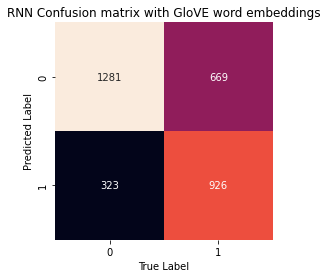

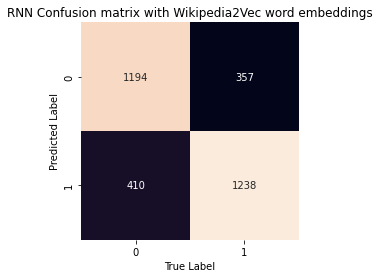


The RNN model's precision is 0.7413931144915933 and the RNN model's recall is 0.580564263322884 using the GloVE word embeddings.

The RNN model's precision is 0.7512135922330098 and the RNN model's recall is 0.7761755485893417 using the Wikipedia2Vec word embeddings.



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

glove_mat = rnn_obj3.conf_mat(y_test)
other_mat = rnn_obj4.conf_mat(y_test)

myax = sns.heatmap(glove_mat.T, square = True, annot = True, fmt = 'd', \
cbar = False).set(title='RNN Confusion matrix with GloVE word embeddings',xlabel='True Label', ylabel='Predicted Label')
plt.savefig('glove_conf_mat.png')
plt.show()

myax = sns.heatmap(other_mat.T, square = True, annot = True, fmt = 'd', \
cbar = False).set(title='RNN Confusion matrix with Wikipedia2Vec word embeddings',xlabel='True Label', ylabel='Predicted Label')
plt.savefig('other_conf_mat.png')
plt.show()

print(f'\nThe RNN model\'s precision is {rnn_mets3[0][0]} and the RNN model\'s recall is {rnn_mets3[0][1]} using the GloVE word embeddings.')
print(f'\nThe RNN model\'s precision is {rnn_mets4[0][0]} and the RNN model\'s recall is {rnn_mets4[0][1]} using the Wikipedia2Vec word embeddings.\n')